# **Импорт модулей**

In [ ]:
!pip install torchinfo
!pip install efficientnet_pytorch
!pip install timm

In [2]:
# Базовые
from pathlib import Path
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
import os
import gc
import sys
import shutil

# Машинное обучение
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, models, transforms
import torch.nn.functional as F
from torchinfo import summary

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

import timm

# Визуализация
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Случайности
import random  

# Сериализация объектов
import dill

# Модель EfficientNet
from efficientnet_pytorch import EfficientNet

In [3]:
#  Фиксируем случайность
seed = 1234
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(seed)

# Проверяем рабочее устройство
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("ATTENTION!!! no GPU found !!!")
print('Device: {}'.format(device))

Device: cuda


In [4]:
# Подключаем диск с входными данными
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Упрощаем относительные пути к входным данным. Задаем корневую рабочую директорию
CWD = f'/content/drive/MyDrive/KarachTcher'
ROOT = Path(CWD)
DIR_TRAIN = ROOT / "train_dataset_train"
DIR_TEST = ROOT / "test_dataset_test"
TAB_TRAIN = DIR_TRAIN / "train.csv" 
TAB_TEST = DIR_TEST / "test.csv"
IMG_TRAIN = DIR_TRAIN / "train" 
IMG_TEST = DIR_TEST / "test"

# **Подготовка данных**

In [6]:
# Посмотрим на количество данных
from os import listdir
print("Обучающей выборки " ,len(listdir(IMG_TRAIN)))
print("Тестовой выборки " ,len(listdir(IMG_TEST)))

Обучающей выборки  4990
Тестовой выборки  2138


In [7]:
# Читаем тренировочный датасет
data_df = pd.read_csv(TAB_TRAIN)
data_df.head(3)
len(data_df)

4990

In [8]:
# Неправильно размеченные снимки и снимки с 2+ объектами в кадре записываем в отдельные списки
avto_list =['4281.jpg']
excavator_list = ['3819.jpg', '6752.jpg']
samosval_list = ['3166.jpg', '5978.jpg']
pogruzchik_list = ['3819.jpg', '5540.jpg', '5730.jpg']
bulldozer_list = ['6997.jpg']
del_list = ['2288.jpg', '2784.jpg', '2853.jpg', '2951.jpg', '3079.jpg', '3123.jpg', '3158.jpg', '3265.jpg',
'3273.jpg', '3368.jpg', '3456.jpg', '3488.jpg', '3500.jpg', '3603.jpg', '3761.jpg', '3765.jpg', '3868.jpg',
'4029.jpg', '4036.jpg', '4229.jpg', '4260.jpg', '4407.jpg', '4430.jpg', '4443.jpg', '4546.jpg', '4602.jpg',
'4791.jpg', '4954.jpg', '5027.jpg', '5150.jpg', '5233.jpg', '5279.jpg', '5366.jpg', '5386.jpg', '5466.jpg',
'5488.jpg', '5552.jpg', '5609.jpg', '5639.jpg', '5682.jpg', '5909.jpg', '5966.jpg', '6105.jpg', '6188.jpg',
'6262.jpg', '6438.jpg', '6442.jpg', '6573.jpg', '6640.jpg', '6641.jpg', '6695.jpg', '6729.jpg', '6861.jpg',
'6922.jpg', '7011.jpg', '7126.jpg']

In [9]:
# Из списков с названиями файлов формируем списки с индексами
avto_indices_list = data_df[data_df['ID_img'].isin(avto_list)].index.to_list() #1.0
excavator_indices_list = data_df[data_df['ID_img'].isin(excavator_list)].index.to_list() #2.0
samosval_indices_list = data_df[data_df['ID_img'].isin(samosval_list)].index.to_list() #4.0
pogruzchik_indices_list = data_df[data_df['ID_img'].isin(pogruzchik_list)].index.to_list() #5.0
bulldozer_indices_list = data_df[data_df['ID_img'].isin(bulldozer_list)].index.to_list() #7.0
del_indices_list = data_df[data_df['ID_img'].isin(del_list)].index.to_list() #drop

In [10]:
# Исправляем ошибки в разметке
for i in avto_indices_list:
    data_df.iloc[i, data_df.columns.get_loc('class')] = 1.0
for j in excavator_indices_list:
    data_df.iloc[j, data_df.columns.get_loc('class')] = 2.0
for k in samosval_indices_list:
    data_df.iloc[k, data_df.columns.get_loc('class')] = 4.0
for l in pogruzchik_indices_list:
    data_df.iloc[l, data_df.columns.get_loc('class')] = 5.0
for m in bulldozer_indices_list:
    data_df.iloc[m, data_df.columns.get_loc('class')] = 7.0

In [11]:
# Удаляем строки с несколькими объектами в кадре
print("Число снимков в датафрейме до удаления" ,len(data_df))
data_df_clean = data_df.drop(index=del_indices_list)
print("Число снимков в датафрейме после удаления" ,len(data_df_clean))

Число снимков в датафрейме до удаления 4990
Число снимков в датафрейме после удаления 4934


In [12]:
# Сохраняем очищенный датафрейм
data_df_clean.to_csv(f'{DIR_TRAIN}/train_clean.csv', index=False)

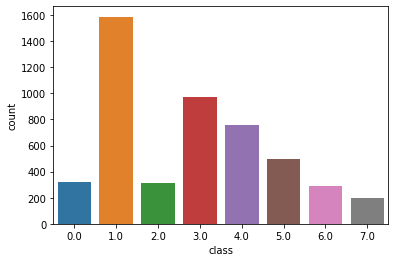

In [13]:
#  Посмотрим на распределение данных в очищенном датафрейме
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
sns.countplot(x = "class" , data  = data_df_clean)

0 - автокран;
1 - легковой автомобиль;
2 - экскаватор;
3 - человек;
4 - самосвал;
5 - карьерный погрузчик;
6 - каток;
7 - бульдозер

# **Загрузка данных**

In [14]:
# Класс для загрузки данных
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform
    def __getitem__(self, idx):
        # достаем имя изображения и его лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']
        # читаем картинку
        image = cv2.imread(f"/content/drive/MyDrive/KarachTcher/train_dataset_train/train/{image_name}") 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label).long()
    def __len__(self):
        return len(self.data_df)

In [15]:
#  Нормализация и кроп центральной зоны
train_transform = transforms.Compose([
    transforms.CenterCrop(102),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.CenterCrop(102),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [16]:
# Разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df_clean,
                                      test_size=0.2, 
                                      random_state=seed)
train_df, valid_df = train_df.reset_index(), valid_df.reset_index()
train_df.shape, valid_df.shape

((3947, 3), (987, 3))

In [17]:
# Применим трансформирование
train_dataset = ImageDataset(train_df,
                             transform = train_transform)
valid_dataset = ImageDataset(valid_df,
                             transform = valid_transform)

In [18]:
# Подготовим загрузчики в нейронную сеть
BATCH_SIZE = 16
NUM_WORKERS = 2

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=NUM_WORKERS)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=BATCH_SIZE,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=1)

In [19]:
# Загрузчик - итерируемый. Посмотрим на train_loader, проверим размеры одной итерации:
for X, y in train_loader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([16, 3, 102, 102])
Shape of y: torch.Size([16]) torch.int64


In [20]:
# Напишем функцию визуализации графиков обучения
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    dd = list(map(lambda x: x.cpu().detach().numpy(), train_history))
    plt.plot(dd, label='train', zorder=1)
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [21]:
# Зададим обратное распространение для обучения
def train(model, criterion, optimizer, train_dataloader, test_dataloader, lr_scheduler, NUM_EPOCH=15,
          accumulate_every_n_epochs=2,
          clip_gradient=True
          ):
    train_loss_log = []
    val_loss_log = []
    train_acc_log = []
    val_acc_log = []
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        train_pred = 0.
        for imgs, labels in train_dataloader:
            optimizer.zero_grad()
            imgs = imgs.cuda()
            labels = labels.cuda()
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            train_pred += (y_pred.argmax(1) == labels).sum()
            optimizer.step()
        train_acc_log.append(train_pred / train_size)
        val_loss = 0.
        val_size = 0
        val_pred = 0.
        model.eval()
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                imgs = imgs.cuda()
                labels = labels.cuda()
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)
                val_pred += (pred.argmax(1) == labels).sum()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)
        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [22]:
# Почистим память
gc.collect()

111

# **Обучение модели. EfficientNetb4**

In [23]:
# Создадим директорию для сохранения весов. Если веса уже созданы на предыдущем этапе и хранятся в этой папке, процедура обучения будет пропущена
!mkdir -p {CWD}/weights/
weights_path = f'{CWD}/weights/efnet_b4_clean_cropCenter102_25+50+25+25+25_20val_32batch.pth'
if Path(weights_path).is_file():
    print('Веса найдены - пропускаем обучение')
else:
    print('Начинаем обучение')

Веса найдены - пропускаем обучение


In [24]:
# EfficientNet B4, когда веса найдены (для GPU)
model2 = models.efficientnet_b4(weights="IMAGENET1K_V1")
model2.classifier[1] = nn.Linear(1792, 8)
if torch.cuda.is_available():
    model2.cuda()
model2.load_state_dict(torch.load('/content/drive/MyDrive/KarachTcher/weights/efnet_b4_clean_cropCenter102_25+50+25+25+25_20val_32batch.pth'))

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

<All keys matched successfully>

In [32]:
# Загрузка весов для CPU
'''
model2 = models.efficientnet_b4(weights="IMAGENET1K_V1")
model2.classifier[1] = nn.Linear(1792, 8)
model2.load_state_dict(torch.load("/content/drive/MyDrive/KarachTcher/weights/efnet_b4_clean_cropCenter102_25+50+25+25+25_20val_32batch.pth", map_location=torch.device('cpu')))
'''

<All keys matched successfully>

In [ ]:
# EfficientNet B4 для начала обучения с начала
'''
model2 = models.efficientnet_b4(weights="IMAGENET1K_V1")
model2.classifier[1] = nn.Linear(1792, 8)

model2 = model2.cuda()
NUM_EPOCH=25 
criterion2 = nn.CrossEntropyLoss()
summary(model2, (8, 3, 100, 100)) 

torch.cuda.empty_cache()
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=0.0005)
lr_scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2,
                                                          T_max=NUM_EPOCH,
                                                          eta_min=0.000001,
                                                          last_epoch=-1)
'''

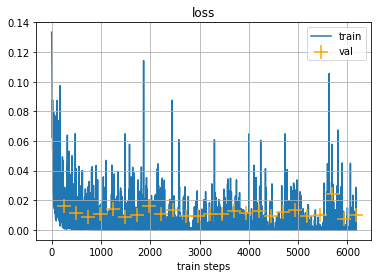

100%|██████████| 25/25 [26:15<00:00, 63.00s/it]

Train loss: 0.162971568280184
Val loss: 1.0214630227443728
Train acc: tensor(99.2146, device='cuda:0')
Val acc: tensor(95.4407, device='cuda:0')


In [ ]:
# Смотрим на график распределения лоссов
'''
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model2, 
                                                                criterion2, 
                                                                optimizer2, 
                                                                train_loader, 
                                                                valid_loader,
                                                                lr_scheduler2,
                                                                NUM_EPOCH=NUM_EPOCH,
                                                                accumulate_every_n_epochs=2,
                                                                clip_gradient=True) 
'''

In [ ]:
# Если нужно сохранить веса
# torch.save(model2.state_dict(), "/content/drive/MyDrive/KarachTcher/weights/efnet_b4_clean_cropCenter102_25+50+25+25+25_20val_32batch+.pth")

In [25]:
# Проверяем точность модели
model2.eval()
gc.collect()
valid_predicts_2 = []
gc.collect()

for imgs, _ in tqdm(valid_loader):
    imgs = imgs.cuda() # закомментировать на cpu
    gc.collect()
    pred = model2(imgs)
    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts_2.append(index)

valid_df["pred"] = valid_predicts_2
val_accuracy = recall_score(valid_df['class'].values, valid_df['pred'].values, average = "macro")
print(f"Validation accuracy = {val_accuracy}")

100%|██████████| 62/62 [00:20<00:00,  3.00it/s]

Validation accuracy = 0.9752989871057841


# **Предсказание**

In [26]:
test_df = pd.read_csv(TAB_TEST)
test_df = test_df.drop(["class"], axis = 1)

In [27]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform
    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['ID_img']
        # читаем картинку
        image = cv2.imread(f"/content/drive/MyDrive/KarachTcher/test_dataset_test/test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        return image
    def __len__(self):
        return len(self.data_df)

In [28]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [29]:
test_loader = torch.utils.data.DataLoader( dataset=test_dataset,
                                           batch_size=8,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

In [30]:
# Почистим память
gc.collect()

44

In [31]:
#model2.eval()
#gc.collect()
predicts = []

for imgs in tqdm(test_loader):
    imgs = imgs.cuda() # закомментировать на cpu
    pred = model2(imgs)
    for class_obj in pred:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)

100%|██████████| 268/268 [06:04<00:00,  1.36s/it]


In [32]:
test_df["class"] = predicts
test_df.head()

,ID_img,class
0,0.jpg,5
1,1.jpg,5
2,2.jpg,1
3,3.jpg,1
4,4.jpg,6


In [34]:
# Создадим директорию для хранения сабмитов. Сохраним сабмит
!mkdir -p {CWD}/submits/
test_df.to_csv("/content/drive/MyDrive/KarachTcher/submits/efnet_b4_clean_cropCenter102_25+50+25+25+25_20val_32batch+.csv", index=False)

# **Дополнительные функции**

In [ ]:
# Сохраняем список изображений в файл
text_file_1 = open(f'{DIR_TRAIN}/img_list3.txt', 'w')
for item in os.listdir(IMG_TRAIN):
    text_file_1.write('%s\n' % item)
text_file_1.close()

In [ ]:
# Загрузчик тренировочных данных на проверку
def train_load(df,target_size=(224,224)):
    array = []
    for file in tqdm(df['ID_img'].values):
            img  = image.load_img(os.path.join(IMG_TRAIN, file), target_size=target_size)
            img = image.img_to_array(img)/255. # нормализация значений тензора
            array.append(img)
            gc.collect()
    return np.asarray(array)

In [ ]:
# Краны
data_kran = data_df.loc[data_df['class']==0.0]
train_data_kran = train_load(data_kran)

In [ ]:
# Визуализируем краны
plt.figure(figsize=(20,80))
for i in range(1,len(data_kran)):
    plt.subplot(33,10,i)
    plt.title(f'{data_kran["ID_img"].values[i]},')
    plt.imshow(train_data_kran[i])
    plt.axis('off')
plt.show()
gc.collect()

In [ ]:
# Функция копирования изображений из папки в папку
def copy_directory (src, dest): 
  src_files = os.listdir(src)
  for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
      shutil.copy(full_file_name, dest)
  print ('Скопировано', len(src_files), 'изображений')

copy_directory (src = f'{DIR_TRAIN}/excavator_new',
                dest = f'{DIR_TRAIN}/train_exc')

In [ ]:
# Функция ресайзинга
def resize(path_in, path_out, new_image_height):
  dir_in = os.listdir(path_in)
  dir_out = os.listdir(path_out)
  for item in dir_in:
    if os.path.isfile(path_in+item):
      image = Image.open(path_in+item)
      file_path_in, extension = os.path.splitext(path_in+item)
      size = image.size
      new_image_width = int(size[1] / size[0] * new_image_height)
      image = image.resize((new_image_height, new_image_width), Image.ANTIALIAS)
      image.save(path_out+item, quality=90)
  print ('Изменены размеры', len(dir_in), 'изображений')

resize (path_in = f'{SAMPLES}/bulldozer_resized/',
        path_out = f'{SAMPLES}/bulldozer_resized2/',
        new_image_height = 128)

In [ ]:
# Задаем упрощенные пути к снимкам 
KRAN_DIR = f'{SAMPLES}/avtokran_resized2' #0
EXC_DIR = f'{SAMPLES}/excavator_resized2' #2
SAM_DIR = f'{SAMPLES}/samosval_resized2'  #4
POG_DIR = f'{SAMPLES}/pogruzchik_resized2'#5
KAT_DIR = f'{SAMPLES}/katok_resized2'     #6
BUL_DIR = f'{SAMPLES}/bulldozer_resized2' #7

In [ ]:
# Пишем функцию создания датафрейма для новых сэмплов с техникой
def make_df (img_dir, type):
  data_new_df = pd.DataFrame({'ID_img': [],
                           'class': []})
  for _, _, files in os.walk(img_dir):
    for file in files:
      if file.endswith('.jpg'):
        new_row = {'ID_img': file, 'class': type}
        data_new_df = data_new_df.append(new_row, ignore_index=True)
  return data_new_df

In [ ]:
# Создаем объединенный датафрейм с новыми образцами техники
kran_df = make_df (img_dir = KRAN_DIR, type = 0.0)
exc_df = make_df (img_dir = EXC_DIR, type = 2.0)
sam_df = make_df(img_dir = SAM_DIR, type = 4.0)
pog_df = make_df (img_dir = POG_DIR, type = 5.0)
kat_df = make_df (img_dir = KAT_DIR, type = 6.0)
bul_df = make_df (img_dir = BUL_DIR, type = 7.0)

frames = [kran_df, exc_df, sam_df, pog_df, kat_df, bul_df]
samples_df = pd.concat(frames, ignore_index=True)
data_sample_df = pd.concat([data_df, samples_df], ignore_index=True)
data_sample_df.head(3)

In [ ]:
# Скачивание снимков
import requests
import time
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool

def download_url(args):
    t0 = time.time()
    url, fn = args[0], args[1]
    try:
        r = requests.get(url)
        with open(fn, 'wb') as f:
            f.write(r.content)
        return(url, time.time() - t0)
    except Exception as e:
        print('Exception in download_url():', e)

In [ ]:
samosval_urls = ["https://serpapi.com/searches/634d1fcf49ecdb7874bad1ba/images/c26f8024a6be94da797ed79dbd0c3d55b436c37cd5336268c4800e07b14d9aa5.jpeg",
"https://serpapi.com/searches/634d1fcf49ecdb7874bad1ba/images/c26f8024a6be94da4a4428de9889606cc8beba093b34c73c222f5f4d0b6379cf.jpeg"]

samosval_fns = [f"/content/drive/MyDrive/KarachTcher/train_dataset_train/samosval_new/sam0001.jpg",
f"/content/drive/MyDrive/KarachTcher/train_dataset_train/samosval_new/sam0002.jpg"]

samosval_inputs = zip(samosval_urls, samosval_fns)

t0 = time.time()
for i in samosval_inputs:
    result = download_url(i)
    print('url:', result[0], 'time:', result[1])
print('Total time:', time.time() - t0)